In [1]:
import numpy as np
import pandas as pd
import torchvision
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from IPython.display import clear_output
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

%matplotlib inline

In [18]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

In [3]:
data = np.loadtxt("./lienard_intermittency.dat")

In [4]:
train = data[:, 1][:45000]
test =  data[:, 1][45000:]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

In [5]:
train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [6]:
train_norm.size()

torch.Size([45000])

In [7]:
train_window = 20

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [8]:
train_inout_seq = create_inout_sequences(train_norm, train_window)
test_inout_seq = create_inout_sequences(test_norm, train_window)

In [21]:
train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=True, drop_last=True)

In [11]:
for x, y in train_dataloader:
    print(torch.reshape(x, (64, 20, 1)).size())
    print(y.view(-1).size())
    break

torch.Size([64, 20, 1])
torch.Size([64])


In [43]:
model = LSTMModel(input_size=1, hidden_layer_size=100, num_layers=2, output_size=1, dropout=0.2)
model = model.to('cuda')

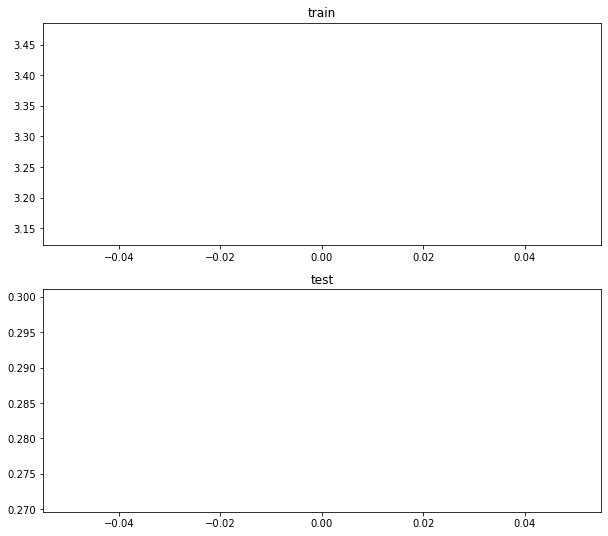

Epoch[1/10] | loss train:3.304251, test:0.285336 | lr:0.001000


In [44]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = torch.reshape(x, (64, 20, 1)).to('cuda')
        y = y.view(-1).to('cuda')

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

losses_train = []
losses_test = []
# begin training
for epoch in range(1):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(test_dataloader)
    scheduler.step()
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, 10, loss_train, loss_val, lr_train))

In [13]:
losses_train[-10:]

[0.0704215386681426,
 0.07110800205475698,
 0.06674818171484276,
 0.06612099710332586,
 0.06921536495929104,
 0.06820152075164287,
 0.06991067216790725,
 0.07092199943326705,
 0.06920091238316672,
 0.06701712318488262]

In [45]:
train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=False, drop_last=True)
val_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=False, drop_last=True)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = torch.reshape(x, (64, 20, 1)).to('cuda')
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = torch.reshape(x, (64, 20, 1)).to('cuda')
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

In [46]:
(((predicted_val*std+mean - np.array(test[20:4948]))**2).mean())**0.5

0.14101350731938403

In [47]:
np.save('LSTM2_lienar', predicted_val*std+mean)

In [42]:
std

0.29032627800080973

In [15]:
test_inout_seq[0][0].size()

torch.Size([20])

In [31]:
seq = test_inout_seq[0][0]
model.eval()
predicted = []
for i in range(len(test_norm)-20):
    x = torch.reshape(seq, (1, 20, 1)).to('cuda')
    out = model(x)
    predicted += out.detach().tolist()
    seq_list = seq.tolist()[1:]
    seq_list.append(out.detach().tolist()[0])
    seq = torch.tensor(seq_list)
  

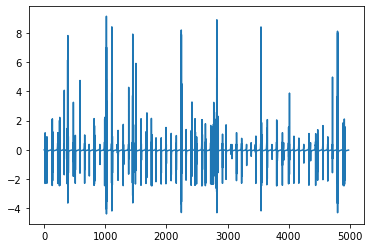

In [32]:
plt.plot(predicted)

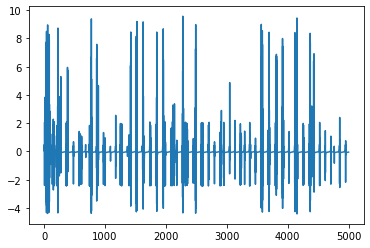

In [33]:
plt.plot(test_norm)

In [15]:
predicted_train.shape

(44928,)

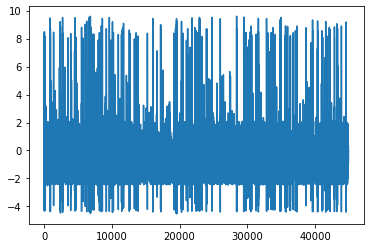

In [16]:
plt.plot(predicted_train)

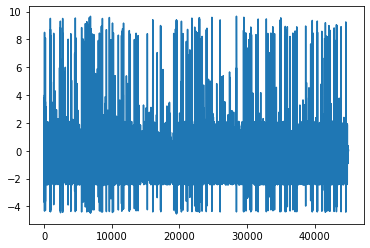

In [17]:
plt.plot(train_norm)

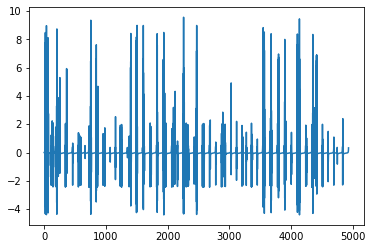

In [18]:
plt.plot(predicted_val)

In [19]:
predicted_val

array([-0.00761448, -0.00348732,  0.00125402, ...,  0.12982139,
        0.19734599,  0.32985872])

In [20]:
test_norm[20:4948]

tensor([-0.0068, -0.0028,  0.0020,  ...,  0.1285,  0.1974,  0.3330])

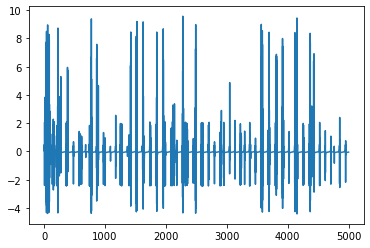

In [21]:
plt.plot(test_norm)

In [13]:
(((predicted_val - np.array(test_norm[20:4948]))**2).mean())**0.5

0.13306581256462272

In [15]:
np.save('LSTM_lienar', predicted_val)